In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from matplotlib.animation import FuncAnimation

In [2]:
df = pd.read_csv("/kaggle/input/historicalweatherdataforindiancities/Temperature_And_Precipitation_Cities_IN/Mumbai_1990_2022_Santacruz.csv")

In [3]:
for col in df:
    print(f"{col} has {((df[col].isnull().sum())/df.shape[0])*100} % values are missing. and Dtypes is {df[col].dtypes}")

time has 0.0 % values are missing. and Dtypes is object
tavg has 0.09248360517908188 % values are missing. and Dtypes is float64
tmin has 20.632251555406086 % values are missing. and Dtypes is float64
tmax has 16.03329409786447 % values are missing. and Dtypes is float64
prcp has 39.355977803934756 % values are missing. and Dtypes is float64


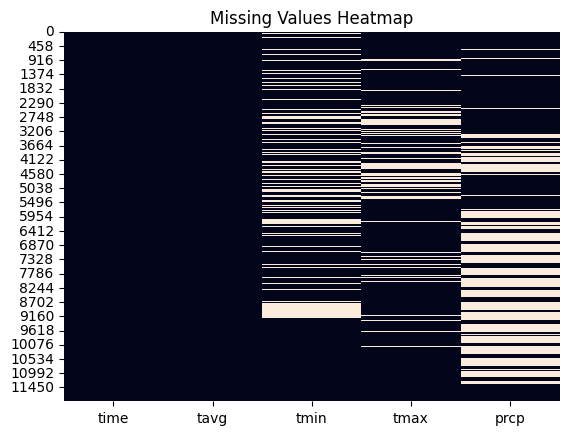

In [4]:
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [5]:
knn = KNNImputer(n_neighbors=5)
df[['tavg', 'tmin', 'tmax', 'prcp']] = knn.fit_transform(df[['tavg', 'tmin', 'tmax', 'prcp']])

In [6]:
df['time'] = pd.to_datetime(df['time'], dayfirst=True)
df.set_index('time', inplace=True)

In [7]:
monthly_climatology = df['tavg'].groupby(df.index.month).mean()
df['month'] = df.index.month
df['year'] = df.index.year
df['tavg_anomaly'] = df['tavg'] - df['month'].map(monthly_climatology)

In [8]:
df_2005 = df[df.index.year == 2005]

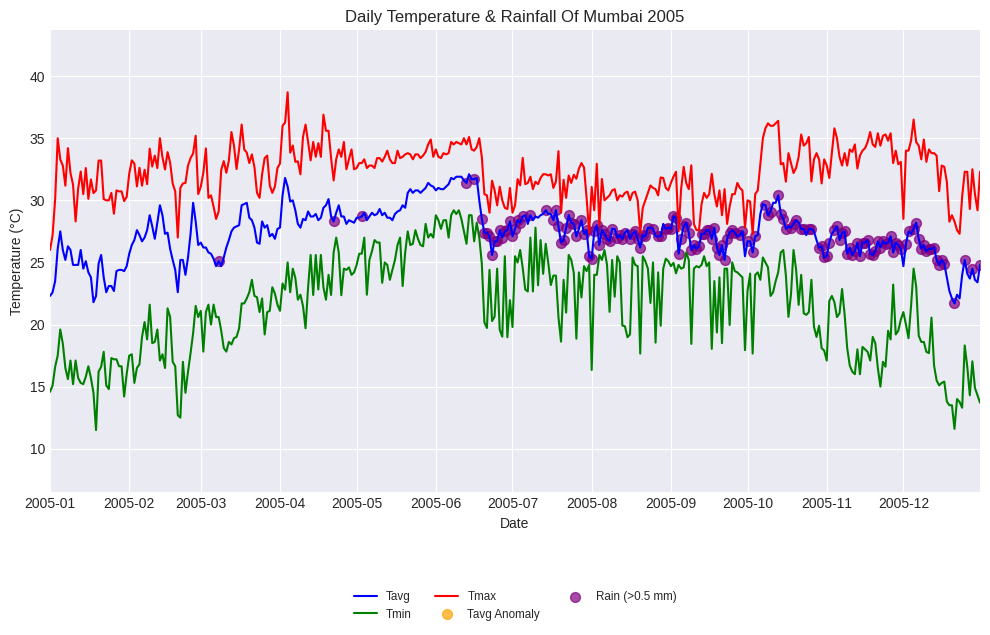

In [9]:
plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots(figsize=(12, 6))

line_tavg, = ax.plot([], [], label='Tavg', color='blue')
line_tmin, = ax.plot([], [], label='Tmin', color='green')
line_tmax, = ax.plot([], [], label='Tmax', color='red')

sc_anomaly = ax.scatter([], [], label='Tavg Anomaly', color='orange', s=50, alpha=0.7)
sc_rain = ax.scatter([], [], label='Rain (>0.5 mm)', color='purple', s=50, alpha=0.7)

ax.set_xlim(df_2005.index.min(), df_2005.index.max())
ax.set_ylim(df_2005[['tmin', 'tmax']].min().min() - 5, df_2005[['tmin', 'tmax']].max().max() + 5)
ax.set_title("Daily Temperature & Rainfall Of Mumbai 2005")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.legend(fontsize='small', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

def update(frame):
    current_data = df_2005.iloc[:frame + 1]
    dates = current_data.index

    line_tavg.set_data(dates, current_data['tavg'])
    line_tmin.set_data(dates, current_data['tmin'])
    line_tmax.set_data(dates, current_data['tmax'])

    sc_anomaly.set_offsets(list(zip(dates, current_data['tavg_anomaly'])))

    rain_days = current_data[current_data['prcp'] > 0.5]
    if not rain_days.empty:
        offsets = list(zip(rain_days.index, rain_days['tavg']))
        sc_rain.set_offsets(offsets)
    else:
        # Pass an empty (0,2) array to avoid IndexError
        sc_rain.set_offsets(np.empty((0, 2)))

    return line_tavg, line_tmin, line_tmax, sc_anomaly, sc_rain

ani = FuncAnimation(fig, update, frames=len(df_2005), interval=30, blit=False)
ani.save('Mumbai_rain_2005.gif', writer='pillow', fps=30)
plt.show()

In [10]:
HTML('<img src="Mumbai_rain_2005.gif" width="1200">')